# 프로그래머스 크롤링

In [ ]:
#import package
import pandas as pd
import requests
import re
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

In [ ]:
#응답률순 AWS 관련 모든 태그 포함

#headers={'User-Agent' : '개인 User-Agent 코드'}
url=''
req=requests.get(url) # headers=headers
content=req.content
soup= BeautifulSoup(content, 'html.parser')
driver=webdriver.Edge()
driver.get(url)

res=pd.DataFrame(columns=['기업명', '사원수', '매출액', '주소', 'JD(직무, 기술스택, 자격요건)', '직급(경력)', '우대사항', '해당 페이지 url', '기업 홈페이지 url'])

company=[] # 기업명
people=[] # 사원수
money=[] # 매출액
address=[] # 주소
JD=[] # JD(직무, 기술스택, 자격요건)
exp=[] # 직급(경력)
treatment=[] # 우대사항
page_url=[] # 해당 페이지 URL
company_url=[] # 기업 홈페이지 URL

# 총 공고 수 계산
jobs=driver.find_element(By.XPATH, '//*[@id="list-positions-wrapper"]/div/div[1]').text
num_jobs=int(re.findall(r'\d+', jobs)[0])

# 총 페이지 수 계산
max_page=num_jobs//20+1
max_page

# 현재 페이지
current_page=1

# 현재 페이지 <= 최대 페이지일 때 다음 실행
while current_page <= max_page:
    url=f'page={current_page}&tags='
    
    try:
        # 현재 페이지의 공고 개수를  가져옴
        num_job_postings = len(driver.find_elements(By.XPATH, '//*[@id="list-positions-wrapper"]/ul/li'))
        
        # 현재 페이지의 공고 개수만큼 다음 반복
        for i in range(1, num_job_postings + 1):
            try:
                # 각 공고 클릭, 창 전환
                driver.find_element(By.XPATH, f'//*[@id="list-positions-wrapper"]/ul/li[{i}]/div[2]/div[1]/h5/a').click() 
                time.sleep(1)
                driver.switch_to.window(driver.window_handles[-1])
                
                time.sleep(2)
                
                # 공고 정보 크롤링
                
                # 기업명
                try:
                    company.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/header/div/div[2]/h4').text)
                except NoSuchElementException:
                    company.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/header/div/div[2]/h4/a').text)
                
                # 사원수, 매출액, 기업 홈페이지 URL은 공고 내에서 기업정보로 페이지 이동 후 크롤링.
                
                # 주소
                try:
                    address.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div[2]/div').text.split('\n')[-1])
                except NoSuchElementException:
                    address.append('')
                # JD(직무, 기술스택, 자격요건)
                # JD - 직무
                try:
                    JD.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div[1]/div[1]').text.split('\n')[-1])
                except NoSuchElementException:
                    JD.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div/div[1]/div[2]').text.split('\n')[-1])
                # JD - 기술스택
                JD_skill_text = driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/div[2]/section').text.split('기술 스택\n')[-1]
                JD.append(re.sub('\s+', ' / ', JD_skill_text))
                # JD - 자격요건
                JD.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/div[3]/section[2]/div').text.split('\n'))
                
                # 직급(경력)
                try:
                    exp.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div[1]/div[4]').text.split('\n')[-1])
                except NoSuchElementException:
                    try:
                        exp.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div[1]/div[3]').text.split('\n')[-1])
                    except NoSuchElementException:
                        exp.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/section/div/div/div[4]/div[2]').text.split('\n')[-1])
                # 우대사항
                treatment.append(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/div[3]/section[3]/div/div').text.split('\n'))
                # 해당 페이지 URL
                page_url.append(driver.current_url)
                
                time.sleep(4)
                
                # 기업 정보 페이지로 이동(기업명 클릭하여 이동)
                try:
                    driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/header/div/div[2]/h4/a').click()
                except:
                    driver.get(driver.find_element(By.XPATH, '//*[@id="career-app-legacy"]/div/div[1]/div[1]/header/div/div[2]/h4/a').get_attribute('href'))
                    
                time.sleep(1)
                
                # 사원수
                # 사원수 가져오기
                people_element = driver.find_elements(By.XPATH, '//*[@id="career-app-legacy"]/div/div/div/div[2]/section[1]/ul/li[2]')
                # '사원수'로 사원수 여부 확인 후 값 가져오기
                if people_element:
                    people_text = people_element[0].text
                    if '사원수' in people_text:
                        people.append((people_text).split('\n')[-1])   
                    else:
                        people.append('')
                        
                # 매출액
                # 매출액 가져오기
                money_element = driver.find_elements(By.XPATH, '//*[@id="career-app-legacy"]/div/div/div/div[2]/section[1]/ul/li[3]')
                # '매출'로 매출액 여부 확인 후 값 가져오기
                if money_element:
                    money_text = money_element[0].text
                    if '매출' in money_text:
                        money.append((money_text).split('\n')[-1])
                    else:
                        try:
                            money.append(driver.find_element(By.XPATH,'//*[@id="career-app-legacy"]/div/div/div/div[2]/section[1]/ul/li[4]').text.split('\n')[-1])
                        except NoSuchElementException:
                            money.append('')
                else:
                    money.append('')
                
                # '바로가기' 버튼에서 기업 홈페이지 URL 가져오기
                company_url.append(driver.find_elements(By.CLASS_NAME, 'list-value')[0].find_element(By.TAG_NAME, 'a').get_attribute('href'))
                
                # 공고 창 닫고 공고 목록 페이지로 전환
                driver.close()
                time.sleep(3)
                
                driver.switch_to.window(driver.window_handles[0])
                
                time.sleep(3)
            
            # 예외(더 이상 공고 없는 경우) 발생 시 break
            except NoSuchElementException:
                print("No more job postings on this page")
                break
                
        # 다음 페이지 버튼 눌러 페이지 이동
        next_page_button = driver.find_element(By.XPATH, '//*[@id="tab_position"]/div[3]/ul/li[7]/span').click()
        time.sleep(2)  # 페이지 로딩 대기
        current_page +=1
        
        # current_page 숫자와 max_page 숫자가 일치되는 경우 종료
        while current_page == max_page:
            break

    # 예외(더 이상 페이지 없는 경우) 발생 시 break
    except Exception as e:
        print("No more pages available")
        break

# temp 데이터 프레임에 저장
temp=pd.DataFrame([company, people, money, address, JD, exp, treatment, page_url, company_url], index=['기업명', '사원수', '매출액', '주소', 'JD(직무, 기술스택, 자격요건)', '직급(경력)', '우대사항', '해당 페이지 url', '기업 홈페이지 url']).T
# res, temp 데이터 프레임 concat
programmers_result=pd.concat([res, temp], ignore_index=True)

# csv 파일로 저장
programmers_result.to_csv('programmers.csv', index=False, encoding='utf-8-sig')

# 점핏 시각화

In [ ]:
page=1
url=''
req=requests.get(url)
content=req.content
soup= BeautifulSoup(content, 'html.parser')

res=pd.DataFrame(columns=['공고명', '기업명', '기술스택', '자격요건', '우대사항', '직급(경력)', '학력', '근무지역', '해당 페이지 url'])

### 크롤링 시 홈페이지 자체의 크롤링 중단으로 인해 정상 작동/중단 시 코드 작성

In [ ]:
# 정상 작동 시 코드

# 데이터를 저장할 리스트 초기화
title = []
name = []
skill = []
jd_condition=[]
treatment=[]
experience = []
lv = []
place = []
page_url=[]

keyword = 'aws'
# 응답률순 aws 점프잇
url = f'&keyword={keyword}'
driver = webdriver.Chrome()
driver.get(url)

i = 1
scroll_down = True  # 스크롤을 최하단까지 내리는 작업이 필요한지 여부를 나타내는 변수

# 공고 클릭, 데이터 추출
while True:
    try:
        # 공고 클릭
        driver.find_element(By.XPATH, f'/html/body/main/div/section[2]/section/div[{i}]/a/div[3]/h2').click()
        time.sleep(2)

        # 공고 데이터 추출
        try:
            # 공고명 데이터를 추출하여 리스트에 추가
            title.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/h1').text)
            # 확인 위한 print
            print("현재 공고:", driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/h1').text)
            
            #기업명 추출
            name.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/div/a').text)
            
            # 기술스택 추출
            try: 
                skill_element = driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[1]/dd/pre')
                skill_text = re.sub('\s+', ' / ', skill_element.text)
                skill.append(skill_text)
            except NoSuchElementException:
                skill.append('')
            
            # 자격요건 추출
            try:
                jd_condition.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[3]/dd/pre').text)
            except NoSuchElementException:
                jd_condition.append('')
                
            # 우대사항 추출
            try:
                treatment.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[4]/dd/pre').text)
            except NoSuchElementException:
                treatment.append('')
                
            time.sleep(2)

            exp_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[1]')
            lv_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[2]')
            place_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[4]')

            # 경력
            if exp_elements:
                exp_text = exp_elements[0].text
                if '경력' in exp_text:
                    exp_text = re.sub('\s+', ' / ', exp_text.split('경력')[-1].strip())
            else:
                exp_text = ''

            experience.append(exp_text)

            # 학력
            if lv_elements:
                lv_text = lv_elements[0].text
                if '학력' in lv_text:
                    lv_text = re.sub('\s+', ' ', lv_text.split('학력')[-1].strip())
            else:
                lv_text = ''

            lv.append(lv_text)

            # 근무지역
            if place_elements:
                place_text = place_elements[0].text
                if '근무지역' in place_text:
                    place_text = re.sub('\s+', ' ', place_text.split('근무지역')[-1].split('지도')[0].strip())
            else:
                place_text = ''

            place.append(place_text)
            
            time.sleep(1)
            
            # 해당 페이지 url
            page_url.append(driver.current_url)


        except NoSuchElementException as e:
            print("Element not found:", e)
        except Exception as e:
            print("Error occurred:", e)

        finally:
            # 이전 페이지로 돌아갑니다.
            driver.execute_script("window.history.go(-1)")
            time.sleep(2)

    except NoSuchElementException:
    # NoSuchElementException가 발생하면 더 이상 클릭할 수 있는 공고가 없으므로 반복문을 종료합니다.
        print("더 이상 클릭할 수 있는 공고가 없습니다.")
        break   
    except ValueError as ve:
        print("ValueError occurred:", ve)
        break
        
    # 인덱스를 증가시켜 다음 공고를 클릭합니다.
    i += 1   
    # 스크롤을 최하단까지 내립니다. (스크롤이 이미 끝까지 내려간 경우에는 스크롤을 내리지 않습니다.)
    if scroll_down:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # 스크롤을 최상단까지 올리기
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(2)

        # 스크롤이 끝까지 내려갔는지 확인합니다.
        new_height = driver.execute_script("return document.body.scrollHeight")
        last_height = driver.execute_script("return window.lastScrollHeight")
        if new_height == last_height:
            scroll_down = False
        else:
            driver.execute_script("window.lastScrollHeight = document.body.scrollHeight;")
    else:
        # 스크롤이 이미 끝까지 내려간 경우에는 스크롤을 내리지 않고 최상단으로 이동합니다.
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(2)


    
temp=pd.DataFrame([title, name, skill, jd_condition, treatment, experience, lv, place, page_url], index=['공고명', '기업명', '기술스택', '자격요건', '우대사항', '직급(경력)', '학력', '근무지역', '해당 페이지 url']).T
jump_result=pd.concat([res, temp], ignore_index=True)

In [ ]:
# 중간에 중단될 시 실행할 코드

# 데이터를 저장할 리스트 초기화
title = []
name = []
skill = []
jd_condition=[]
treatment=[]
experience = []
lv = []
place = []
page_url=[]

keyword = 'aws'
# 응답률순 aws 점프잇
url = f'&keyword={keyword}'
driver = webdriver.Chrome()
driver.get(url)

i = 1
scroll_down = True  # 스크롤을 최하단까지 내리는 작업이 필요한지 여부를 나타내는 변수

# 중단된 부분부터 다시 시작하는지 여부를 나타내는 변수
resume = False

if resume:
    # 이어서 시작할 경우, 기존에 저장된 데이터 불러오기
    res = pd.read_csv('jumpit_data.csv')

    # 기존에 수집한 공고의 개수에 따라 인덱스 설정
    i = len(res)

    # 이미 방문한 페이지의 URL 리스트 생성
    visited_urls = list(res['해당 페이지 url'])
else:
    # 처음부터 시작하는 경우 빈 데이터프레임 생성
    res = pd.DataFrame()

# 공고 클릭, 데이터 추출
while True:
    try:
        # 공고 클릭
        driver.find_element(By.XPATH, f'/html/body/main/div/section[2]/section/div[{i}]/a/div[3]/h2').click()
        time.sleep(2)

        # 공고 데이터 추출
        try:
            # 공고명 데이터를 추출하여 리스트에 추가
            title.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/h1').text)
            # 확인 위한 print
            print("현재 공고:", driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/h1').text)
            
            #기업명 추출
            name.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[1]/div/a').text)
            
            # 기술스택 추출
            try: 
                skill_element = driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[1]/dd/pre')
                skill_text = re.sub('\s+', ' / ', skill_element.text)
                skill.append(skill_text)
            except NoSuchElementException:
                skill.append('')
            
            # 자격요건 추출
            try:
                jd_condition.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[3]/dd/pre').text)
            except NoSuchElementException:
                jd_condition.append('')
                
            # 우대사항 추출
            try:
                treatment.append(driver.find_element(By.XPATH, '/html/body/main/div/div[1]/div/section[2]/dl[4]/dd/pre').text)
            except NoSuchElementException:
                treatment.append('')
                
            time.sleep(2)

            exp_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[1]')
            lv_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[2]')
            place_elements = driver.find_elements(By.XPATH, '/html/body/main/div/div[1]/div/section[3]/dl[4]')

            # 경력
            if exp_elements:
                exp_text = exp_elements[0].text
                if '경력' in exp_text:
                    exp_text = re.sub('\s+', ' / ', exp_text.split('경력')[-1].strip())
            else:
                exp_text = ''

            experience.append(exp_text)

            # 학력
            if lv_elements:
                lv_text = lv_elements[0].text
                if '학력' in lv_text:
                    lv_text = re.sub('\s+', ' ', lv_text.split('학력')[-1].strip())
            else:
                lv_text = ''

            lv.append(lv_text)

            # 근무지역
            if place_elements:
                place_text = place_elements[0].text
                if '근무지역' in place_text:
                    place_text = re.sub('\s+', ' ', place_text.split('근무지역')[-1].split('지도')[0].strip())
            else:
                place_text = ''

            place.append(place_text)
            
            time.sleep(1)
            
            # 해당 페이지 url
            page_url.append(driver.current_url)


        except NoSuchElementException as e:
            print("Element not found:", e)
        except Exception as e:
            print("Error occurred:", e)

        finally:
            # 이전 페이지로 돌아갑니다.
            driver.execute_script("window.history.go(-1)")
            time.sleep(2)

    except NoSuchElementException:
    # NoSuchElementException가 발생하면 더 이상 클릭할 수 있는 공고가 없으므로 반복문을 종료합니다.
        print("더 이상 클릭할 수 있는 공고가 없습니다.")
        break   
    except ValueError as ve:
        print("ValueError occurred:", ve)
        break
        
    # 인덱스를 증가시켜 다음 공고를 클릭합니다.
    i += 1   
    # 스크롤을 최하단까지 내립니다. (스크롤이 이미 끝까지 내려간 경우에는 스크롤을 내리지 않습니다.)
    if scroll_down:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # 스크롤을 최상단까지 올리기
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(2)

        # 스크롤이 끝까지 내려갔는지 확인합니다.
        new_height = driver.execute_script("return document.body.scrollHeight")
        last_height = driver.execute_script("return window.lastScrollHeight")
        if new_height == last_height:
            scroll_down = False
        else:
            driver.execute_script("window.lastScrollHeight = document.body.scrollHeight;")
    else:
        # 스크롤이 이미 끝까지 내려간 경우에는 스크롤을 내리지 않고 최상단으로 이동합니다.
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(2)


    
temp=pd.DataFrame([title, name, skill, jd_condition, treatment, experience, lv, place, page_url], index=['공고명', '기업명', '기술스택', '자격요건', '우대사항', '직급(경력)', '학력', '근무지역', '해당 페이지 url']).T
jump_result=pd.concat([res, temp], ignore_index=True)
# 데이터를 CSV 파일로 저장
jump_result.to_csv('jumpit_data.csv', index=False, encoding='utf-8-sig')

# 크롤링 정보 시각화

In [4]:
import pandas as pd

# xlsx 파일을 읽어서 데이터프레임으로 변환
df = pd.read_excel('/crawling_result_final.xlsx')

In [ ]:
def extract_district(address):
    district = None
    # 주소 열이 문자열이 아닌 경우 빈 값을 반환
    if not isinstance(address, str):
        return district
    
    # 주소를 공백이나 쉼표 등을 기준으로 분리하여 각 부분을 리스트로 저장
    address_parts = address.split()
    # 주소의 각 부분에서 '구, 시'로 끝나는 부분을 찾아 구 정보 추출
    for part in address_parts:
        if part.endswith('구'):
            district = part
        elif part.endswith('시'):
            district = part
            break
    return district

# 각 주소에서 구 정보 추출하여 새로운 열로 추가
df['구'] = df['주소'].apply(extract_district)

# 결과 확인
print(df[['주소', '구']])

In [14]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium

# re 데이터프레임에서 주소 열 가져오기
addresses = df['구'].tolist()

# Nominatim 객체 생성
geolocator = Nominatim(user_agent="my_geocoder")

# 주소를 좌표로 변환하여 저장할 리스트
coordinates = []

# 주소를 좌표로 변환
for address in addresses:
    location = geolocator.geocode(address)
    if location:
        coordinates.append([location.latitude, location.longitude])
    else:
        # 변환 실패 시 0, 0 좌표로 처리
        coordinates.append([0, 0])

# 좌표가 포함된 데이터프레임 생성
df_coordinates = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

# 지도 생성
mymap = folium.Map(location=[37.5665, 126.9780], zoom_start=10)

# 변환된 좌표를 지도에 마커로 표시
for index, row in df_coordinates.iterrows():
    popup_text = addresses[index]  # 주소 정보를 팝업 텍스트로 추가
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip="Click me!"
    ).add_to(mymap)

# 지도를 HTML 파일로 저장하거나 인라인으로 표시
mymap


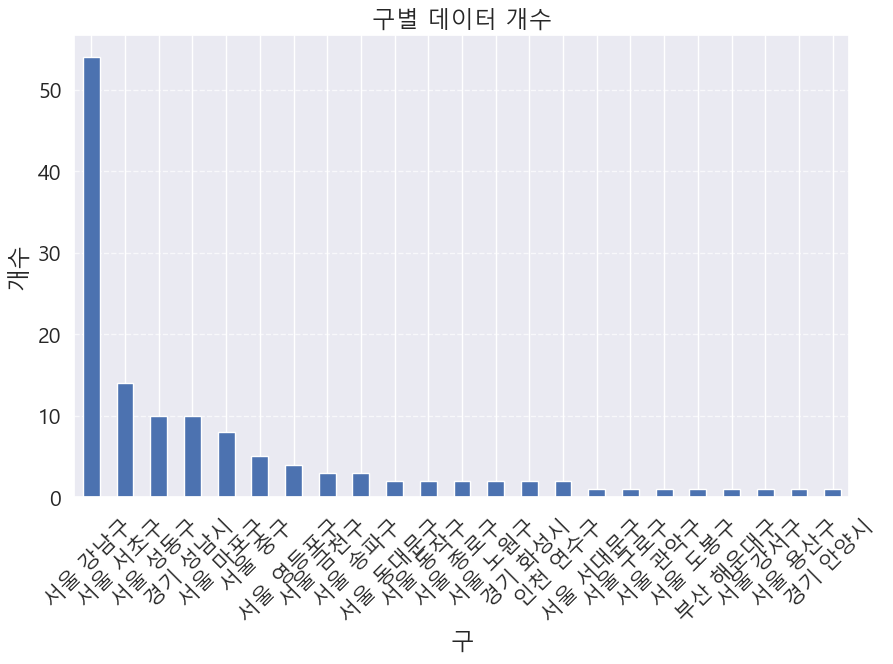

In [6]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set(font_scale=1.4)
# 맑은 고딕으로 글꼴 설정하기
plt.rc('font', family='Malgun Gothic') 
# 마이너스 기호 문제 해결하기
mpl.rcParams['axes.unicode_minus'] = False

# 각 구의 개수(count)를 계산
count_by_district = df['시/군/구'].value_counts()

# 시각화 그래프 그리기
plt.figure(figsize=(10, 6))
count_by_district.plot(kind='bar')
plt.title('구별 데이터 개수')
plt.xlabel('구')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


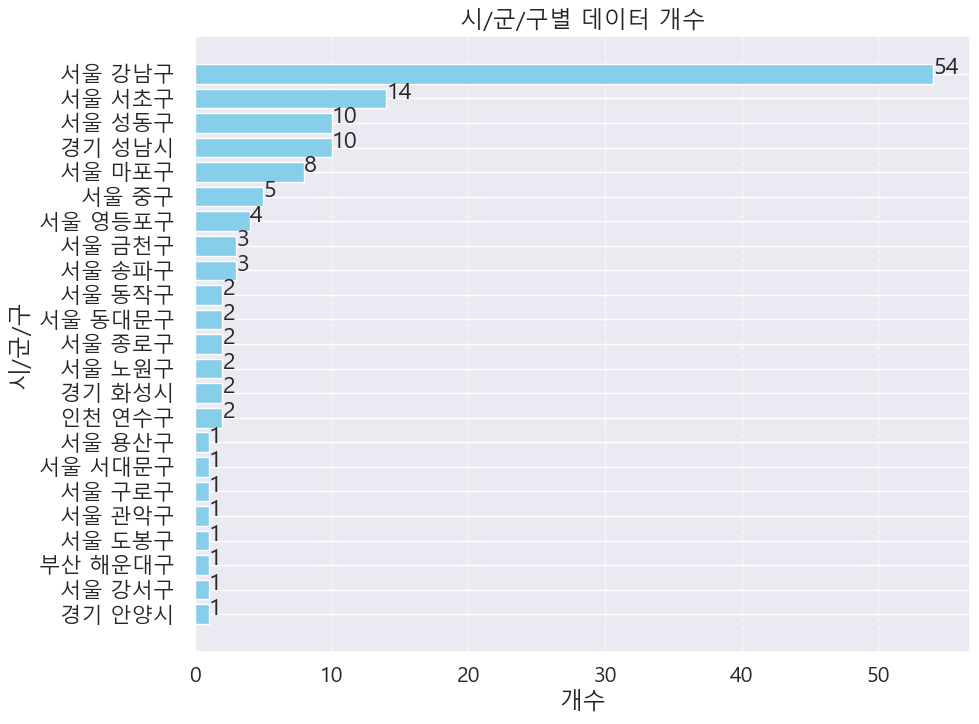

In [21]:
# 각 구의 개수(count)를 계산
count_by_district = df['시/군/구'].value_counts().reset_index()
count_by_district.columns = ['시/군/구', 'count']  # 컬럼명 변경

# 시각화 그래프 그리기
plt.figure(figsize=(10, 8))
count_by_district_sorted = count_by_district.sort_values(by='count', ascending=True)  # 개수(count)로 정렬
plt.barh(count_by_district_sorted['시/군/구'], count_by_district_sorted['count'], color='skyblue')
for index, value in enumerate(count_by_district_sorted['count']):
    plt.text(value, index, str(value))  # 각 바에 값 표시
plt.xlabel('개수')
plt.ylabel('시/군/구')
plt.title('시/군/구별 데이터 개수')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()